# Substructure에 해당하는 부분을 표시

In [1]:
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

print('RDKit version:', rdkit.__version__)

RDKit version: 2018.09.2


* Substructure 설정

In [2]:
substructure_smiles = 'C=C'
substructure_mol = Chem.MolFromSmiles(substructure_smiles)

* Substructure를 검색할 분자 설정

In [3]:
mol = Chem.MolFromSmiles('C=Cc1ccc([H])cc1')
Chem.Kekulize(mol) # aromatic인 bond type을 single, double 로 바꿔줘야 C=C 를 찾을 수 있다.

단순하게는 mol 객체에서 GetSubstructureMatch 를 이용하면 된다.

In [4]:
# https://stackoverflow.com/questions/61659643/rdkit-how-to-draw-high-resolution-chemical-structure
# http://rdkit.blogspot.com/2020/04/new-drawing-options-in-202003-release.html

def moltosvg(mol, substructure, molSize = (300,300), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    hit_bonds = []
    hit_ats = list(mol.GetSubstructMatch(substructure))
    
    for bond in substructure.GetBonds():
        aid1 = hit_ats[bond.GetBeginAtomIdx()]
        aid2 = hit_ats[bond.GetEndAtomIdx()]
        hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
    print(hit_bonds)
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,highlightAtoms=hit_ats, highlightBonds=hit_bonds)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

[0]


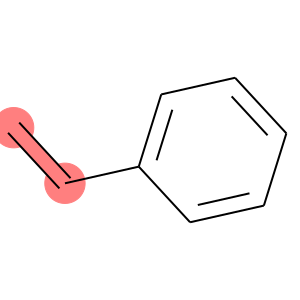

In [5]:
SVG(moltosvg(mol, substructure_mol))

하지만 이 방법은 분자내에 존재하는 모든 substructure를 찾아서 표시해주지 않는다.  
**GetSubstructMatches** 를 이용하면 모든 substurcture를 찾아서 리스트로 만들어준다.  
**GetSubstructMatches**를 이용한다.  

표시해야할 atoms, bonds 를 리스트로 저장한 후,  
이 리스트를 highlight 를 해야되는 대상으로 이용한다.

In [6]:
def moltosvg(mol, substructure, molSize = (300,300), kekulize = True):
    Chem.Kekulize(mol)
    mc = Chem.Mol(mol.ToBinary())
    hit_bonds = []
    hit_ats = list(mol.GetSubstructMatches(substructure))
    
    hit_ats_list = []
    for i in hit_ats:
        for j in i:
            hit_ats_list.append(j)
    
    for i in hit_ats:
        for bond in substructure.GetBonds():
            #print('1:', bond)
            aid1 = list(i)[bond.GetBeginAtomIdx()]
            aid2 = list(i)[bond.GetEndAtomIdx()]
            hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
            #print('2:', hit_bonds)


    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,highlightAtoms=hit_ats_list, highlightBonds=hit_bonds)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


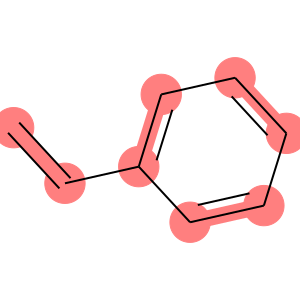

In [7]:
SVG(moltosvg(mol, substructure_mol))

이미지 저장

In [8]:
with open('mol_image.svg', 'w') as svg_file:
    svg_file.write(
        SVG(moltosvg(mol, substructure_mol)).data
    )

# References  
* https://stackoverflow.com/questions/69735586/how-to-highlight-the-substructure-of-a-molecule-with-thick-red-lines-in-rdkit-as  
* https://stackoverflow.com/questions/67189346/how-to-save-ipython-core-display-svg-as-png-file
* https://github.com/rdkit/rdkit-tutorials/issues/5